(opt_tax_recur)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Optimal Taxation with State-Contingent Debt

```{contents} Contents
:depth: 2
```

In addition to what's in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install --upgrade quantecon
!pip install interpolation

## Overview

This lecture describes a celebrated model of optimal fiscal policy by Robert E.
Lucas, Jr., and Nancy Stokey  {cite}`LucasStokey1983`.

The model revisits classic issues about how to pay for a war.

Here a *war* means a more  or less temporary surge in an exogenous government expenditure process.

The model features

* a government that must finance an exogenous stream of government expenditures with  either
    * a flat rate tax on labor, or
    * purchases and sales from a full array of Arrow state-contingent securities
* a representative household that values consumption and leisure
* a linear production function mapping labor into a single good
* a Ramsey planner who at time $t=0$ chooses a plan for taxes and
  trades of [Arrow securities](https://en.wikipedia.org/wiki/Arrow_security) for all $t \geq 0$

After first presenting the model in a space of sequences, we shall represent it
recursively in terms of two Bellman equations formulated along lines that we
encountered in {doc}`Dynamic Stackelberg models <dyn_stack>`.

As in {doc}`Dynamic Stackelberg models <dyn_stack>`, to apply dynamic programming
we shall define the state vector artfully.

In particular, we shall include forward-looking variables that summarize  optimal
responses of private agents to a Ramsey plan.

See {doc}`Optimal taxation <lqramsey>` for analysis within a linear-quadratic setting.

Let's start with some standard imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import root
from quantecon import MarkovChain
from quantecon.optimize.nelder_mead import nelder_mead
from interpolation import interp
from numba import njit, prange, float64
from numba.experimental import jitclass

## A Competitive Equilibrium with Distorting Taxes

At time $t \geq 0$ a random variable $s_t$ belongs to a time-invariant
set ${\cal S} = [1, 2, \ldots, S]$.

For $t \geq 0$, a history $s^t = [s_t, s_{t-1}, \ldots, s_0]$ of an
exogenous state $s_t$ has joint probability density $\pi_t(s^t)$.

We begin by assuming that government purchases $g_t(s^t)$ at time $t \geq 0$ depend on $s^t$.

Let $c_t(s^t)$,  $\ell_t(s^t)$, and $n_t(s^t)$ denote consumption,
leisure, and labor supply, respectively, at history $s^t$ and date $t$.

A representative  household is endowed with one unit of time that can be divided
between leisure $\ell_t$ and labor $n_t$:

```{math}
:label: feas1_opt_tax

n_t(s^t) + \ell_t(s^t) = 1
```

Output equals $n_t(s^t)$ and can be divided between $c_t(s^t)$ and $g_t(s^t)$

```{math}
:label: TSs_techr_opt_tax

c_t(s^t) + g_t(s^t) = n_t(s^t)
```

A representative household's preferences over $\{c_t(s^t), \ell_t(s^t)\}_{t=0}^\infty$ are ordered by

```{math}
:label: TS_prefr_opt_tax

\sum_{t=0}^\infty \sum_{s^t} \beta^t \pi_t(s^t) u[c_t(s^t), \ell_t(s^t)]
```

where the utility function $u$ is  increasing, strictly concave, and three
times continuously differentiable in both arguments.

The technology pins down a pre-tax wage rate to unity for all $t, s^t$.

The government imposes a flat-rate tax $\tau_t(s^t)$ on labor income at
time $t$, history $s^t$.

There are complete markets in one-period Arrow securities.

One unit of an Arrow security  issued at time $t$ at history $s^t$
and promising to pay one unit of time $t+1$ consumption in state $s_{t+1}$
costs $p_{t+1}(s_{t+1}|s^t)$.

The government issues one-period Arrow securities each period.

The government has a sequence of budget constraints whose time $t \geq 0$ component is

```{math}
:label: TS_govr

g_t(s^t) =   \tau_t(s^t)  n_t(s^t) + \sum_{s_{t+1}} p_{t+1}(s_{t+1} | s^t) b_{t+1}(s_{t+1} | s^t) -
b_t(s_t | s^{t-1})
```

where

* $p_{t+1}(s_{t+1}|s^t)$ is a competitive equilibrium price of one unit of
  consumption at date $t+1$ in state $s_{t+1}$ at date $t$ and history $s^t$.
* $b_t(s_t|s^{t-1})$ is government debt falling due at time $t$, history $s^t$.

Government debt $b_0(s_0)$ is an exogenous initial condition.

The representative household has a sequence of budget constraints whose time $t\geq 0$ component is

```{math}
:label: TS_bcr

c_t(s^t) + \sum_{s_{t+1}} p_t(s_{t+1} | s^t) b_{t+1}(s_{t+1} | s^t)
=  \left[1-\tau_t(s^t)\right]  n_t(s^t) + b_t(s_t | s^{t-1}) \quad \forall t \geq 0
```

A  **government policy** is an exogenous sequence $\{g(s_t)\}_{t=0}^\infty$,
a tax rate sequence $\{\tau_t(s^t)\}_{t=0}^\infty$, and a government debt sequence $\{b_{t+1}(s^{t+1})\}_{t=0}^\infty$.

A **feasible allocation** is a consumption-labor supply plan $\{c_t(s^t), n_t(s^t)\}_{t=0}^\infty$
that satisfies {eq}`TSs_techr_opt_tax` at all $t, s^t$.

A **price system** is a sequence of Arrow security prices $\{p_{t+1}(s_{t+1} | s^t) \}_{t=0}^\infty$.

The household faces the price system as a price-taker and takes the government policy as given.

The household chooses $\{c_t(s^t), \ell_t(s^t)\}_{t=0}^\infty$ to maximize {eq}`TS_prefr_opt_tax` subject to {eq}`TS_bcr` and {eq}`feas1_opt_tax` for all $t, s^t$.

A **competitive equilibrium with distorting taxes** is a feasible allocation,
a price system, and a government policy such that

* Given the price system and the government policy, the allocation solves the
  household's optimization problem.
* Given the allocation, government policy, and  price system, the government's
  budget constraint is satisfied for all $t, s^t$.

Note: There are many competitive equilibria with distorting taxes.

They are indexed by different government policies.

The **Ramsey problem** or **optimal taxation problem** is to choose a competitive
equilibrium with distorting taxes that maximizes {eq}`TS_prefr_opt_tax`.

### Arrow-Debreu Version of Price System

We find it convenient sometimes to work with the Arrow-Debreu price system that is
implied by a sequence of Arrow securities prices.

Let $q_t^0(s^t)$ be the price at time $0$, measured in time $0$
consumption goods, of one unit of consumption at time $t$,
history $s^t$.

The following recursion relates Arrow-Debreu prices $\{q_t^0(s^t)\}_{t=0}^\infty$
to Arrow securities prices $\{p_{t+1}(s_{t+1}|s^t)\}_{t=0}^\infty$

```{math}
:label: TS_foc

q^0_{t+1}(s^{t+1}) = p_{t+1}(s_{t+1}|s^t) q^0_t(s^t) \quad s.t. \quad q_0^0(s^0) = 1
```

Arrow-Debreu prices are useful when we want to compress a sequence of budget
constraints into a single intertemporal budget constraint, as we shall find it
convenient to do below.

### Primal Approach

We apply a popular approach to solving a Ramsey problem, called the *primal approach*.

The idea is to use first-order conditions for household optimization to
eliminate taxes and prices in favor of quantities, then pose an optimization problem
cast entirely in terms of quantities.

After Ramsey quantities have been found, taxes and prices can then be unwound
from the allocation.

The primal approach uses four steps:

1. Obtain  first-order conditions of the household's problem and solve them for $\{q^0_t(s^t), \tau_t(s^t)\}_{t=0}^\infty$ as functions of
   the allocation $\{c_t(s^t), n_t(s^t)\}_{t=0}^\infty$.
1. Substitute these expressions for taxes and prices in terms of the allocation
   into the household's present-value budget constraint.
    * This intertemporal constraint involves only the allocation and is regarded
      as an *implementability constraint*.
1. Find the allocation that maximizes the utility of the representative household
   {eq}`TS_prefr_opt_tax` subject to  the feasibility constraints {eq}`feas1_opt_tax`
   and {eq}`TSs_techr_opt_tax`  and the implementability condition derived in step 2.
    * This optimal allocation is called the **Ramsey allocation**.
1. Use the Ramsey  allocation together with the formulas from step 1 to find
   taxes and prices.

### The Implementability Constraint

By sequential substitution of one one-period budget constraint {eq}`TS_bcr` into
another, we can obtain the household's present-value budget constraint:

```{math}
:label: TS_bcPV2

\sum_{t=0}^\infty \sum_{s^t} q^0_t(s^t) c_t(s^t) =
\sum_{t=0}^\infty \sum_{s^t} q^0_t(s^t) [1-\tau_t(s^t)] n_t(s^t) +
b_0
```

$\{q^0_t(s^t)\}_{t=1}^\infty$ can be interpreted as a time $0$
Arrow-Debreu price system.

To approach the Ramsey problem, we study the household's optimization problem.

First-order conditions for the household’s problem for $\ell_t(s^t)$
and $b_t(s_{t+1}| s^t)$, respectively, imply

```{math}
:label: LSA_taxr

(1 - \tau_t(s^t)) = {\frac{u_l(s^t)}{u_c(s^t)}}
```

and

```{math}
:label: LS101

p_{t+1}(s_{t+1}| s^t) = \beta \pi(s_{t+1} | s^t) \left({\frac{u_c(s^{t+1})}{u_c({s^t})}} \right)
```

where $\pi(s_{t+1} | s^t)$ is the probability distribution of $s_{t+1}$
conditional on history $s^t$.

Equation {eq}`LS101` implies that the Arrow-Debreu price system satisfies

```{math}
:label: LS102

q_t^0(s^t) = \beta^{t} \pi_{t}(s^{t})
                            {u_c(s^{t})  \over u_c(s^0)}
```

(The stochastic process $\{q_t^0(s^t)\}$ is an instance of what finance economists call a *stochastic discount factor* process.)

Using the first-order conditions {eq}`LSA_taxr` and {eq}`LS101` to eliminate
taxes and prices from {eq}`TS_bcPV2`, we derive the *implementability condition*

```{math}
:label: TSs_cham1

\sum_{t=0}^\infty  \sum_{s^t} \beta^t \pi_t(s^t)
         [u_c(s^t) c_t(s^t) - u_\ell(s^t) n_t(s^t)] -
         u_c(s^0) b_0 = 0
```

The **Ramsey problem** is to choose a feasible  allocation  that maximizes

```{math}
:label: TS_prefr2

\sum_{t=0}^\infty \sum_{s^t} \beta^t \pi_t(s^t) u[c_t(s^t), 1 - n_t(s^t)]
```

subject to  {eq}`TSs_cham1`.

### Solution Details

First, define a "pseudo utility function"

```{math}
:label: TS_cham17

V\left[c_t(s^t), n_t(s^t), \Phi\right] =
u[c_t(s^t),1-n_t(s^t)] +
\Phi \left[ u_c(s^t) c_t(s^t) -
u_\ell(s^t) n_t(s^t) \right]
```

where $\Phi$ is a Lagrange multiplier on the implementability condition {eq}`TS_bcPV2`.

Next form the Lagrangian

```{math}
:label: TS_chamlag

J  = \sum_{t=0}^\infty
\sum_{s^t} \beta^t \pi_t(s^t)
\Bigl\{
    V[c_t(s^t), n_t(s^t), \Phi]   + \theta_t(s^t)
   \Bigl[ n_t(s^t) - c_t(s^t) - g_t(s_t) \Bigr]
\Bigr\} - \Phi u_c(0) b_0
```

where  $\{\theta_t(s^t); \forall s^t\}_{t\geq0}$ is a sequence of Lagrange
multipliers on the feasible conditions {eq}`TSs_techr_opt_tax`.

Given an initial government debt $b_0$,  we want to maximize $J$
with respect to $\{c_t(s^t), n_t(s^t); \forall s^t \}_{t\geq0}$   and to minimize with respect
to $\Phi$ and with respect to $\{\theta(s^t); \forall s^t \}_{t\geq0}$.

The first-order conditions for the Ramsey problem for periods $t \geq 1$ and $t=0$, respectively, are

```{math}
:label: eqFONCRamsey1

\begin{aligned}
    c_t(s^t)\rm{:} &
    \; (1+\Phi) u_c(s^t) + \Phi \left[u_{cc}(s^t) c_t(s^t) -
    u_{\ell c}(s^t) n_t(s^t) \right]  - \theta_t(s^t) = 0, \quad t \geq 1
    \\
    n_t(s^t)\rm{:} &
    \; -(1+\Phi) u_{\ell}(s^t) - \Phi \left[u_{c\ell}(s^t) c_t(s^t) -
    u_{\ell \ell}(s^t) n_t(s^t) \right] + \theta_t(s^t) = 0, \quad t \geq 1
\end{aligned}
```

and

```{math}
:label: eqFONCRamsey0

\begin{aligned}
    c_0(s^0, b_0)\rm{:} &
    \; (1+\Phi) u_c(s^0, b_0) + \Phi \left[u_{cc}(s^0, b_0) c_0(s^0, b_0) -
    u_{\ell c}(s^0, b_0) n_0(s^0, b_0) \right]  - \theta_0(s^0, b_0)   \\
       & \quad \quad \quad \quad \quad \quad  - \Phi u_{cc}(s^0, b_0) b_0 = 0
    \\
    n_0(s^0, b_0)\rm{:} &
    \; -(1+\Phi) u_{\ell}(s^0, b_0) - \Phi \left[u_{c\ell}(s^0, b_0) c_0(s^0, b_0) -
    u_{\ell \ell}(s^0, b_0) n_0(s^0, b_0) \right] + \theta_0(s^0, b_0) \\
      & \quad \quad \quad \quad \quad \quad + \Phi u_{c \ell}(s^0, b_0) b_0 = 0
\end{aligned}
```

Please note how these first-order conditions differ between $t=0$ and $t \geq 1$.

It is instructive to use first-order conditions {eq}`eqFONCRamsey1` for
$t \geq 1$ to eliminate the multipliers $\theta_t(s^t)$.

For convenience, we suppress the time subscript and the index $s^t$ and obtain

```{math}
:label: TS_barg

\begin{aligned}
  (1+\Phi) &u_c(c,1-c-g) + \Phi \bigl[c u_{cc}(c,1-c-g) -
  (c+g) u_{\ell c}(c,1-c-g) \bigr]
    \\
    &= (1+\Phi) u_{\ell}(c,1-c-g) + \Phi \bigl[c u_{c\ell}(c,1-c-g) -
    (c+g) u_{\ell \ell}(c,1-c-g)  \bigr]
\end{aligned}
```

where we have imposed conditions {eq}`feas1_opt_tax` and {eq}`TSs_techr_opt_tax`.

Equation {eq}`TS_barg` is one equation that can be solved to express the
unknown $c$ as a function of the  exogenous variable $g$ and the Lagrange multiplier $\Phi$.

We also know that  time $t=0$ quantities $c_0$ and $n_0$ satisfy

```{math}
:label: TS_barg_aust

\begin{aligned}
      (1+\Phi) &u_c(c,1-c-g) + \Phi \bigl[c u_{cc}(c,1-c-g) -
      (c+g) u_{\ell c}(c,1-c-g) \bigr]
        \\
        &= (1+\Phi) u_{\ell}(c,1-c-g) + \Phi \bigl[c u_{c\ell}(c,1-c-g) -
        (c+g) u_{\ell \ell}(c,1-c-g)  \bigr] + \Phi (u_{cc} - u_{c,\ell}) b_0
\end{aligned}
```

Notice that a counterpart to $b_0$ does *not* appear
in {eq}`TS_barg`, so $c$ does not *directly* depend on it for $t \geq 1$.

But things are different for time $t=0$.

An analogous argument for the $t=0$ equations {eq}`eqFONCRamsey0` leads
to one equation that can be solved for $c_0$ as a function of the
pair $(g(s_0), b_0)$ and the Lagrange multiplier $\Phi$.

These outcomes mean that the following statement would be  true even when
government purchases are history-dependent functions $g_t(s^t)$ of the
history of $s^t$.

**Proposition:**
If government purchases are equal after two histories
$s^t$ and $\tilde s^\tau$ for $t,\tau\geq0$, i.e., if

$$
g_t(s^t) = g^\tau(\tilde s^\tau) = g
$$

then it follows from {eq}`TS_barg` that the Ramsey  choices of consumption and leisure,
$(c_t(s^t),\ell_t(s^t))$ and $(c_j(\tilde s^\tau),\ell_j(\tilde
s^\tau))$, are identical.

The proposition asserts that the optimal allocation is a function of the
currently realized quantity of government purchases $g$ only and does
*not* depend on the specific history that preceded that realization of $g$.

### The Ramsey Allocation for a Given Multiplier

Temporarily take  $\Phi$ as given.

We shall compute $c_0(s^0, b_0)$ and $n_0(s^0, b_0)$ from the first-order
conditions {eq}`eqFONCRamsey0`.

Evidently, for $t \geq 1$, $c$ and
$n$ depend on the time $t$ realization of $g$ only.

But for $t=0$, $c$ and $n$  depend on both $g_0$ and the
government’s initial debt $b_0$.

Thus, while $b_0$
influences $c_0$ and $n_0$, there appears no analogous
variable $b_t$ that influences $c_t$ and $n_t$ for
$t \geq 1$.

The absence of $b_t$ as a direct determinant of the  Ramsey allocation for
$t \geq 1$ and its presence for $t=0$ is a symptom of the
*time-inconsistency* of a Ramsey plan.

Of course, $b_0$ affects the Ramsey allocation for $t \geq 1$ *indirectly* through
its effect on $\Phi$.

$\Phi$ has to take a value that assures that
the household and the government’s budget constraints are both
satisfied at a candidate Ramsey allocation and price system associated
with that $\Phi$.

### Further Specialization

At this point, it is useful to specialize the model in the following ways.

We assume that $s$ is governed by a finite state Markov chain with states
$s\in [1, \ldots, S]$ and transition matrix $\Pi$, where

$$
\Pi(s'|s) = {\rm Prob}(s_{t+1} = s'| s_t =s)
$$

Also, assume that government purchases $g$ are an exact time-invariant function
$g(s)$ of $s$.

We maintain these assumptions throughout the remainder of this lecture.

### Determining the Lagrange Multiplier

We complete the Ramsey plan by computing the Lagrange multiplier $\Phi$
on the implementability constraint {eq}`TSs_cham1`.

Government budget balance restricts $\Phi$ via the following line of reasoning.

The household's first-order conditions imply

```{math}
:label: LSA_ta

(1 - \tau_t(s^t)) = {\frac{u_l(s^t)}{u_c(s^t)} }
```

and the  implied one-period Arrow securities prices

```{math}
:label: LSA_Arro

p_{t+1}(s_{t+1}| s^t) = \beta \Pi(s_{t+1} | s_t) {\frac{u_c(s^{t+1})}{u_c({s^t})}}
```

Substituting from  {eq}`LSA_ta`, {eq}`LSA_Arro`, and the feasibility
condition {eq}`TSs_techr_opt_tax`  into the recursive version {eq}`TS_bcr` of
the household budget constraint gives

```{math}
:label: LSA_budget

\begin{aligned}
    u_c(s^t) [ n_t(s^t) - g_t(s^t)] +
    \beta \sum_{s_{t+1}} \Pi (s_{t+1}| s_t) u_c(s^{t+1}) b_{t+1}(s_{t+1} | s^t) \\ =
    u_l (s^t) n_t(s^t) + u_c(s^t) b_t(s_t | s^{t-1})
\end{aligned}
```

Define $x_t(s^t) = u_c(s^t) b_t(s_t | s^{t-1})$.

Notice that $x_t(s^t)$ appears on the right side of {eq}`LSA_budget` while
$\beta$ times the conditional expectation of
$x_{t+1}(s^{t+1})$ appears on the left side.

Hence the equation shares much of the structure of a simple asset pricing equation with
$x_t$ being analogous to the price of the asset at time $t$.

We learned earlier that for a Ramsey allocation
$c_t(s^t), n_t(s^t)$, and $b_t(s_t|s^{t-1})$, and therefore
also $x_t(s^t)$, are each functions of $s_t$ only,  being
independent of the history $s^{t-1}$ for $t \geq 1$.

That means that we can express equation {eq}`LSA_budget` as

```{math}
:label: LSA_budget2

u_c(s)
[ n(s) - g(s)]  + \beta
\sum_{s'} \Pi(s' | s) x'(s')  = u_l(s) n(s) + x(s)
```

where $s'$ denotes a next period value of $s$ and
$x'(s')$ denotes a next period value of $x$.

Given $n(s)$ for $s = 1, \ldots , S$, equation {eq}`LSA_budget2` is easy to solve for $x(s)$ for
$s = 1, \ldots , S$.

If we let $\vec n, \vec g, \vec x$
denote $S \times 1$ vectors whose $i$th elements are the
respective $n, g$, and $x$ values when $s=i$, and let
$\Pi$ be the transition matrix for the Markov state $s$,
then we can express {eq}`LSA_budget2` as the matrix equation

```{math}
:label: LSA_budget20

\vec u_c(\vec n - \vec g) + \beta \Pi \vec x = \vec u_l \vec n + \vec x
```

This is a system of $S$ linear equations in the $S \times 1$
vector $x$, whose solution is

```{math}
:label: LSA_xsol

\vec x= (I - \beta \Pi )^{-1} [ \vec u_c (\vec n-\vec g) - \vec u_l \vec n]
```

In these equations, by $\vec u_c \vec n$, for example, we mean
element-by-element multiplication of the two vectors.

After solving for $\vec x$, we can find $b(s_t|s^{t-1})$ in Markov
state $s_t=s$ from $b(s) = {\frac{x(s)}{u_c(s)}}$ or the matrix equation

```{math}
:label: LSA_bsol

\vec b = {\frac{ \vec x }{\vec u_c}}
```

where division here means an element-by-element division of the respective
components of the $S \times 1$ vectors $\vec x$ and
$\vec u_c$.

Here is a computational algorithm:

1. Start with a guess for the value for $\Phi$, then use the
   first-order conditions and the feasibility conditions to compute
   $c(s_t), n(s_t)$ for $s \in [1,\ldots, S]$ and
   $c_0(s_0,b_0)$ and $n_0(s_0, b_0)$, given $\Phi$.
    * these are $2  (S+1)$ equations in $2  (S+1)$ unknowns.
1. Solve the $S$ equations {eq}`LSA_xsol` for the $S$ elements
   of $\vec x$.
    * these depend on $\Phi$.
1. Find a $\Phi$ that satisfies
   
   ```{math}
   :label: Bellman2cons
   
   u_{c,0} b_0 = u_{c,0} (n_0 - g_0) - u_{l,0} n_0  + \beta \sum_{s=1}^S \Pi(s | s_0) x(s)
   ```
   by gradually raising $\Phi$ if the left side of {eq}`Bellman2cons`
   exceeds the right side and lowering $\Phi$ if the left side is less than the right side.
1. After computing a Ramsey allocation,  recover the flat tax rate on
   labor from {eq}`LSA_taxr` and the implied one-period Arrow securities
   prices from {eq}`LS101`.

In summary, when $g_t$ is a time-invariant function of a Markov state
$s_t$, a Ramsey plan can be constructed by solving $3S +3$
equations for $S$ components each of $\vec c$, $\vec n$, and
$\vec x$ together with $n_0, c_0$, and $\Phi$.

### Time Inconsistency

Let $\{\tau_t(s^t)\}_{t=0}^\infty, \{b_{t+1}(s_{t+1}| s^t)\}_{t=0}^\infty$
be a time $0$, state $s_0$ Ramsey plan.

Then $\{\tau_j(s^j)\}_{j=t}^\infty, \{b_{j+1}(s_{j+1}| s^j)\}_{j=t}^\infty$
is a time $t$, history $s^t$ continuation of a time
$0$, state $s_0$ Ramsey plan.

A time $t$, history $s^t$ Ramsey plan is a Ramsey plan that
starts from initial conditions $s^t, b_t(s_t|s^{t-1})$.

A time $t$, history $s^t$
continuation of a time $0$, state $0$ Ramsey plan is
*not* a time $t$, history $s^t$ Ramsey plan.

The means that a Ramsey plan is *not time consistent*.

Another way to say the same thing is that a Ramsey plan is *time inconsistent*.

The reason is that a continuation Ramsey plan takes $u_{ct} b_t(s_t|s^{t-1})$ as given, not
$b_t(s_t|s^{t-1})$.

We shall discuss this more below.

### Specification with CRRA Utility

In our calculations below and in a {doc}`subsequent lecture <amss>` based on an *extension* of the Lucas-Stokey model
by  Aiyagari, Marcet, Sargent, and Seppälä (2002) {cite}`aiyagari2002optimal`, we shall modify the one-period utility function assumed above.

(We adopted the preceding utility specification because it was the one used in  the original Lucas-Stokey paper {cite}`LucasStokey1983`. We shall soon  revert to that specification in a subsequent section.)

We will  modify their specification by instead assuming that the  representative agent has  utility function

$$
u(c,n) = {\frac{c^{1-\sigma}}{1-\sigma}} - {\frac{n^{1+\gamma}}{1+\gamma}}
$$

where  $\sigma > 0$, $\gamma >0$.

We continue to assume that

$$
c_t + g_t = n_t
$$

We eliminate leisure from the model.

We also eliminate Lucas and Stokey's restriction that $\ell_t + n_t \leq 1$.

We replace these two things with the assumption that
labor $n_t \in [0, +\infty]$.

With these adjustments, the analysis of Lucas and Stokey prevails once we make the following replacements

$$
\begin{aligned}
u_\ell(c, \ell) &\sim - u_n(c, n) \\
u_c(c,\ell) &\sim u_c(c,n) \\
u_{\ell,\ell}(c,\ell) &\sim u_{nn}(c,n) \\
u_{c,c}(c,\ell)& \sim u_{c,c}(c,n) \\
u_{c,\ell} (c,\ell) &\sim 0
\end{aligned}
$$

With these understandings, equations {eq}`TS_barg` and {eq}`TS_barg_aust` simplify in the case of the CRRA utility function.

They become

```{math}
:label: TS_barg10

(1+\Phi) [u_c(c) + u_n(c+g)] + \Phi[c u_{cc}(c) + (c+g) u_{nn}(c+g)] = 0
```

and

```{math}
:label: TS_barg11

(1+\Phi) [u_c(c_0) + u_n(c_0+g_0)] + \Phi[c_0 u_{cc}(c_0) + (c_0+g_0) u_{nn}(c_0+g_0)] - \Phi u_{cc}(c_0) b_0 = 0
```

In equation {eq}`TS_barg10`, it is understood that $c$ and $g$ are each functions of the Markov state $s$.

In addition, the time $t=0$ budget constraint is satisfied at $c_0$ and initial government debt
$b_0$:

```{math}
:label: opt_tax_eqn_10

b_0 + g_0 = \tau_0 (c_0 + g_0) + \beta  \sum_{s=1}^S \Pi(s | s_0) \frac{u_c(s)}{u_{c,0}} b_1(s)
```

where $\tau_0$ is the time $t=0$ tax rate.

In equation {eq}`opt_tax_eqn_10`, it is understood that

$$
\begin{aligned}
\tau_0 = 1 - \frac{u_{l,0}}{u_{c,0}}
\end{aligned}
$$

### Sequence Implementation

The above steps are implemented in a class called SequentialLS

In [3]:
class SequentialLS:

    '''
    Class that takes a preference object, state transition matrix,
    and state contingent government expenditure plan as inputs, and
    solves the sequential allocation problem described above.
    It returns optimal allocations about consumption and labor supply,
    as well as the multiplier on the implementability constraint Φ.
    '''

    def __init__(self,
                 pref,
                 π=np.full((2, 2), 0.5),
                 g=np.array([0.1, 0.2])):

        # Initialize from pref object attributes
        self.β, self.π, self.g = pref.β, π, g
        self.mc = MarkovChain(self.π)
        self.S = len(π)  # Number of states
        self.pref = pref

        # Find the first best allocation
        self.find_first_best()

    def FOC_first_best(self, c, g):
        '''
        First order conditions that characterize
        the first best allocation.
        '''

        pref = self.pref
        Uc, Ul = pref.Uc, pref.Ul

        n = c + g
        l = 1 - n

        return Uc(c, l) - Ul(c, l)

    def find_first_best(self):
        '''
        Find the first best allocation
        '''
        S, g = self.S, self.g

        res = root(self.FOC_first_best, np.full(S, 0.5), args=(g,))

        if (res.fun > 1e-10).any():
            raise Exception('Could not find first best')

        self.cFB = res.x
        self.nFB = self.cFB + g

    def FOC_time1(self, c, Φ, g):
        '''
        First order conditions that characterize
        optimal time 1 allocation problems.
        '''

        pref = self.pref
        Uc, Ucc, Ul, Ull, Ulc = pref.Uc, pref.Ucc, pref.Ul, pref.Ull, pref.Ulc

        n = c + g
        l = 1 - n

        LHS = (1 + Φ) * Uc(c, l) + Φ * (c * Ucc(c, l) - n * Ulc(c, l))
        RHS = (1 + Φ) * Ul(c, l) + Φ * (c * Ulc(c, l) - n * Ull(c, l))

        diff = LHS - RHS

        return diff

    def time1_allocation(self, Φ):
        '''
        Computes optimal allocation for time t >= 1 for a given Φ
        '''
        pref = self.pref
        S, g = self.S, self.g

        # use the first best allocation as intial guess
        res = root(self.FOC_time1, self.cFB, args=(Φ, g))

        if (res.fun > 1e-10).any():
            raise Exception('Could not find LS allocation.')

        c = res.x
        n = c + g
        l = 1 - n

        # Compute x
        I = pref.Uc(c, n) * c - pref.Ul(c, l) * n
        x = np.linalg.solve(np.eye(S) - self.β * self.π, I)

        return c, n, x

    def FOC_time0(self, c0, Φ, g0, b0):
        '''
        First order conditions that characterize
        time 0 allocation problem.
        '''

        pref = self.pref
        Ucc, Ulc = pref.Ucc, pref.Ulc

        n0 = c0 + g0
        l0 = 1 - n0

        diff = self.FOC_time1(c0, Φ, g0)
        diff -= Φ * (Ucc(c0, l0) - Ulc(c0, l0)) * b0

        return diff

    def implementability(self, Φ, b0, s0, cn0_arr):
        '''
        Compute the differences between the RHS and LHS
        of the implementability constraint given Φ,
        initial debt, and initial state.
        '''

        pref, π, g, β = self.pref, self.π, self.g, self.β
        Uc, Ul = pref.Uc, pref.Ul
        g0 = self.g[s0]

        c, n, x = self.time1_allocation(Φ)

        res = root(self.FOC_time0, cn0_arr[0], args=(Φ, g0, b0))
        c0 = res.x
        n0 = c0 + g0
        l0 = 1 - n0

        cn0_arr[:] = c0, n0

        LHS = Uc(c0, l0) * b0
        RHS = Uc(c0, l0) * c0 - Ul(c0, l0) * n0 + β * π[s0] @ x

        return RHS - LHS

    def time0_allocation(self, b0, s0):
        '''
        Finds the optimal time 0 allocation given
        initial government debt b0 and state s0
        '''

        # use the first best allocation as initial guess
        cn0_arr = np.array([self.cFB[s0], self.nFB[s0]])

        res = root(self.implementability, 0., args=(b0, s0, cn0_arr))

        if (res.fun > 1e-10).any():
            raise Exception('Could not find time 0 LS allocation.')

        Φ = res.x[0]
        c0, n0 = cn0_arr

        return Φ, c0, n0

    def τ(self, c, n):
        '''
        Computes τ given c, n
        '''
        pref = self.pref
        Uc, Ul = pref.Uc, pref.Ul

        return 1 - Ul(c, 1-n) / Uc(c, 1-n)

    def simulate(self, b0, s0, T, sHist=None):
        '''
        Simulates planners policies for T periods
        '''
        pref, π, β = self.pref, self.π, self.β
        Uc = pref.Uc

        if sHist is None:
            sHist = self.mc.simulate(T, s0)

        cHist, nHist, Bhist, τHist, ΦHist = np.empty((5, T))
        RHist = np.empty(T-1)

        # Time 0
        Φ, cHist[0], nHist[0] = self.time0_allocation(b0, s0)
        τHist[0] = self.τ(cHist[0], nHist[0])
        Bhist[0] = b0
        ΦHist[0] = Φ

        # Time 1 onward
        for t in range(1, T):
            c, n, x = self.time1_allocation(Φ)
            τ = self.τ(c, n)
            u_c = Uc(c, 1-n)
            s = sHist[t]
            Eu_c = π[sHist[t-1]] @ u_c
            cHist[t], nHist[t], Bhist[t], τHist[t] = c[s], n[s], x[s] / u_c[s], τ[s]
            RHist[t-1] = Uc(cHist[t-1], 1-nHist[t-1]) / (β * Eu_c)
            ΦHist[t] = Φ

        gHist = self.g[sHist]
        yHist = nHist

        return [cHist, nHist, Bhist, τHist, gHist, yHist, sHist, ΦHist, RHist]


## Recursive Formulation of the Ramsey Problem

We now temporarily revert to Lucas and Stokey's specification.

We start by noting that $x_t(s^t) = u_c(s^t) b_t(s_t | s^{t-1})$ in equation {eq}`LSA_budget`
appears to be a purely “forward-looking” variable.

But $x_t(s^t)$ is  a  natural candidate for a state variable in
a recursive formulation of the Ramsey problem, one that records history-dependence and so is
`backward-looking`.

### Intertemporal Delegation

To express a Ramsey plan recursively, we imagine that a time $0$
Ramsey planner is followed by a sequence of continuation Ramsey planners
at times $t = 1, 2, \ldots$.

A “continuation Ramsey planner” at time $t \geq 1$ has a
different objective function and faces different constraints and state variables than does the
Ramsey planner at time $t =0$.

A key step in representing a Ramsey plan recursively is
to regard the marginal utility scaled government debts
$x_t(s^t) = u_c(s^t) b_t(s_t|s^{t-1})$ as predetermined quantities
that continuation Ramsey planners at times $t \geq 1$ are
obligated to attain.

Continuation Ramsey planners do this by choosing continuation policies that induce the representative
household to make choices that imply that $u_c(s^t) b_t(s_t|s^{t-1})= x_t(s^t)$.

A time $t \geq 1$ continuation Ramsey planner faces $x_t, s_t$ as
state variables.

A time $t\geq 1$ continuation Ramsey planner
delivers $x_t$ by choosing a suitable $n_t, c_t$ pair and a list of
$s_{t+1}$-contingent continuation quantities $x_{t+1}$ to
bequeath to a time $t+1$ continuation Ramsey planner.

While a time $t \geq 1$ continuation Ramsey planner faces $x_t, s_t$ as
state variables,  the time $0$ Ramsey planner faces $b_0$, not $x_0$,
as a state variable.

Furthermore, the Ramsey planner cares about $(c_0(s_0), \ell_0(s_0))$, while
continuation Ramsey planners do not.

The time $0$ Ramsey planner
hands a state-contingent function that make $x_1$ a function of $s_1$ to a time $1$, state $s_1$
continuation Ramsey planner.

These lines of delegated authorities and
responsibilities across time express the continuation Ramsey planners’
obligations to implement their parts of an original Ramsey plan that had been
designed once-and-for-all at time $0$.

### Two Bellman Equations

After $s_t$ has been realized at time $t \geq 1$, the state
variables confronting the time $t$ **continuation Ramsey planner** are
$(x_t, s_t)$.

* Let $V(x, s)$ be the value of a **continuation Ramsey plan** at $x_t = x, s_t =s$ for $t \geq 1$.
* Let $W(b, s)$ be the value of a **Ramsey plan** at time $0$ at $b_0=b$ and $s_0 = s$.

We work backward by preparing a Bellman equation for
$V(x,s)$ first, then a Bellman equation for $W(b,s)$.

### The Continuation Ramsey Problem

The Bellman equation for a time $t \geq 1$ continuation Ramsey
planner is

```{math}
:label: LSA_Bellman1

V(x, s) = \max_{n, \{x'(s')\}} u(n-g(s), 1-n) + \beta \sum_{s'\in S} \Pi(s'| s) V(x', s')
```

where maximization over $n$ and the $S$ elements of
$x'(s')$ is subject to the single implementability constraint for
$t \geq 1$:

```{math}
:label: LSA_Bellman1cons

x = u_c(n-g(s)) -  u_l n + \beta \sum_{s' \in {\cal S}} \Pi(s' | s) x'(s')
```

Here $u_c$ and $u_l$ are today’s values of the marginal utilities.

For each given value of $x, s$, the continuation Ramsey planner chooses $n$ and $x'(s')$
for each $s' \in {\cal S}$.

Associated with a value function $V(x,s)$ that solves Bellman equation {eq}`LSA_Bellman1`
are $S+1$ time-invariant policy functions

```{math}
:label: RRpolicyt

\begin{aligned}
    n_t & = f(x_t, s_t), \quad t \geq 1
    \\
    x_{t+1}(s_{t+1}) & = h(s_{t+1}; x_t, s_t), \, s_{t+1} \in  {\cal S}, \, t \geq 1
\end{aligned}
```

### The Ramsey Problem

The Bellman equation of  the time $0$ Ramsey planner is

```{math}
:label: LSA_Bellman2

W(b_0, s_0) = \max_{n_0, \{x'(s_1)\}} u(n_0 - g_0, 1 - n_0) + \beta \sum_{s_1 \in {\cal S}} \Pi(s_1| s_0) V( x'(s_1), s_1)
```

where maximization over $n_0$ and the $S$ elements of
$x'(s_1)$ is subject to the time $0$ implementability
constraint

```{math}
:label: Bellman2cons2

u_{c,0} b_0 = u_{c,0} (n_0 - g_0) - u_{l,0} n_0  + \beta \sum_{s_1\in {\cal S}} \Pi(s_1 | s_0) x'(s_1)
```

coming from restriction {eq}`Bellman2cons`.

Associated with a value function $W(b_0, n_0)$ that solves  Bellman equation {eq}`LSA_Bellman2` are
$S +1$ time $0$ policy functions

```{math}
:label: RRpolicy0

\begin{aligned}
    n_0
        & = f_0(b_0, s_0) \cr
    x_1(s_1)
        & = h_0(s_1; b_0, s_0)
\end{aligned}
```

Notice the appearance of state variables $(b_0, s_0)$ in the time
$0$ policy functions for the Ramsey planner as compared to
$(x_t, s_t)$ in the policy functions {eq}`RRpolicyt` for the time $t \geq 1$
continuation Ramsey planners.

The value function $V(x_t, s_t)$ of the time $t$
continuation Ramsey planner equals
$E_t \sum_{\tau = t}^\infty \beta^{\tau - t} u(c_\tau, l_\tau)$, where
consumption and leisure processes are evaluated along the original
time $0$ Ramsey plan.

### First-Order Conditions

Attach a Lagrange multiplier $\Phi_1(x,s)$ to constraint {eq}`LSA_Bellman1cons` and a
Lagrange multiplier $\Phi_0$ to constraint {eq}`Bellman2cons`.

Time $t \geq 1$: First-order conditions for the time $t \geq 1$ constrained
maximization problem on the right side of the continuation Ramsey
planner’s Bellman equation {eq}`LSA_Bellman1` are

```{math}
:label: LSARxt

\beta \Pi(s' | s) V_x (x', s') - \beta \Pi(s' | s) \Phi_1 = 0
```

for $x'(s')$ and

```{math}
:label: LSARnt

(1 + \Phi_1) (u_c - u_l ) + \Phi_1 \left[ n (u_{ll} - u_{lc}) + (n-g(s)) (u_{cc} - u_{lc})  \right] = 0
```

for $n$.

Given $\Phi_1$, equation {eq}`LSARnt` is one equation to be
solved for $n$ as a function of $s$ (or of $g(s)$).

Equation {eq}`LSARxt` implies $V_x(x', s')= \Phi_1$, while an envelope
condition is $V_x(x,s) = \Phi_1$, so it follows that

```{math}
:label: LSAenv

V_x(x', s') = V_x(x,s) = \Phi_1(x,s)
```

Time $t=0$: For the time $0$ problem on the right side of the Ramsey planner’s
Bellman equation {eq}`LSA_Bellman2`,  first-order conditions are

```{math}
:label: LSAx0

V_x(x(s_1), s_1) = \Phi_0
```

for $x(s_1), s_1 \in  {\cal S}$, and

```{math}
:label: LSAn0

\begin{aligned}
    (1 + \Phi_0) (u_{c,0} - u_{n,0})
    & + \Phi_0 \bigl[ n_0 (u_{ll,0} - u_{lc,0} ) +  (n_0 - g(s_0)) (u_{cc,0} - u_{cl,0}) \Bigr]
    \\
    & \quad \quad \quad -  \Phi_0 (u_{cc,0} - u_{cl,0}) b_0  =  0
\end{aligned}
```

Notice  similarities and differences between the first-order
conditions for $t \geq 1$ and for $t=0$.

An additional term is present in {eq}`LSAn0` except in  three special cases

* $b_0 = 0$, or
* $u_c$ is constant (i.e., preferences are quasi-linear in consumption), or
* initial government assets are sufficiently large to finance all government
  purchases with interest earnings from those assets so that $\Phi_0= 0$

Except in these special cases, the allocation and the labor tax rate as
functions of $s_t$ differ between dates $t=0$ and subsequent
dates $t \geq 1$.

Naturally, the first-order conditions in this recursive formulation of the
Ramsey problem agree with the first-order conditions derived when we first
formulated the Ramsey plan in the space of sequences.

### State Variable Degeneracy

Equations {eq}`LSAenv` and {eq}`LSAx0` imply that $\Phi_0 = \Phi_1$
and that

```{math}
:label: FONCx

V_x(x_t, s_t) = \Phi_0
```

for all $t \geq 1$.

When $V$ is concave in $x$, this implies *state-variable degeneracy*
along a Ramsey plan in the sense that for $t \geq 1$, $x_t$ will be
a time-invariant function of $s_t$.

Given $\Phi_0$, this function mapping $s_t$ into $x_t$
can be expressed as a vector $\vec x$ that solves equation {eq}`Bellman2cons2`
for $n$ and $c$ as functions of $g$ that are associated
with $\Phi = \Phi_0$.

### Manifestations of Time Inconsistency

While the marginal utility adjusted level of government debt $x_t$
is a key state variable for the continuation Ramsey planners at
$t \geq 1$, it is not a state variable at time $0$.

The time $0$ Ramsey planner faces $b_0$, not $x_0 = u_{c,0} b_0$, as a state variable.

The discrepancy in state variables faced by the time $0$ Ramsey planner and the time
$t \geq 1$ continuation Ramsey planners captures the differing
obligations and incentives faced by the time $0$ Ramsey planner
and the time $t \geq 1$ continuation Ramsey planners.

* The time $0$ Ramsey planner is obligated to honor government
  debt $b_0$ measured in time $0$ consumption goods.
* The time $0$ Ramsey planner can manipulate the *value* of government
  debt as measured by $u_{c,0} b_0$.
* In contrast, time $t \geq 1$ continuation Ramsey planners are
  obligated *not* to alter values of debt, as measured by
  $u_{c,t} b_t$, that they inherit from a preceding Ramsey planner or
  continuation Ramsey planner.

When government expenditures $g_t$ are a time-invariant function
of a Markov state $s_t$, a Ramsey plan and associated Ramsey
allocation feature marginal utilities of consumption $u_c(s_t)$
that, given $\Phi$, for $t \geq 1$ depend only on
$s_t$, but that for $t=0$ depend on $b_0$ as well.

This means that $u_c(s_t)$ will be a time-invariant function of
$s_t$ for $t \geq 1$, but except when $b_0 = 0$, a
different function for $t=0$.

This in turn means that prices of
one-period Arrow securities $p_{t+1}(s_{t+1} | s_t) = p(s_{t+1}|s_t)$
will be the *same* time-invariant functions of $(s_{t+1}, s_t)$
for $t \geq 1$, but a different function $p_0(s_1|s_0)$ for
$t=0$, except when $b_0=0$.

The differences between these
time $0$ and time $t \geq 1$ objects reflect
the Ramsey planner’s incentive to manipulate Arrow security prices and,
through them, the value of initial government debt $b_0$.

### Recursive Implementation

The above steps are implemented in a class called `RecursiveLS`.

In [4]:
class RecursiveLS:

    '''
    Compute the planner's allocation by solving Bellman
    equation.
    '''

    def __init__(self,
                 pref,
                 x_grid,
                 π=np.full((2, 2), 0.5),
                 g=np.array([0.1, 0.2])):

        self.π, self.g, self.S = π, g, len(π)
        self.pref, self.x_grid = pref, x_grid

        bounds = np.empty((self.S, 2))

        # bound for n
        bounds[0] = 0, 1

        # bound for xprime
        for s in range(self.S-1):
            bounds[s+1] = x_grid.min(), x_grid.max()

        self.bounds = bounds

        # initialization of time 1 value function
        self.V = None

    def time1_allocation(self, V=None, tol=1e-7):
        '''
        Solve the optimal time 1 allocation problem
        by iterating Bellman value function.
        '''

        π, g, S = self.π, self.g, self.S
        pref, x_grid, bounds = self.pref, self.x_grid, self.bounds

        # initial guess of value function
        if V is None:
            V = np.zeros((len(x_grid), S))

        # initial guess of policy
        z = np.empty((len(x_grid), S, S+2))

        # guess of n
        z[:, :, 1] = 0.5

        # guess of xprime
        for s in range(S):
            for i in range(S-1):
                z[:, s, i+2] = x_grid

        while True:
            # value function iteration
            V_new, z_new = T(V, z, pref, π, g, x_grid, bounds)

            if np.max(np.abs(V - V_new)) < tol:
                break

            V = V_new
            z = z_new

        self.V = V_new
        self.z1 = z_new
        self.c1 = z_new[:, :, 0]
        self.n1 = z_new[:, :, 1]
        self.xprime1 = z_new[:, :, 2:]

        return V_new, z_new

    def time0_allocation(self, b0, s0):
        '''
        Find the optimal time 0 allocation by maximization.
        '''

        if self.V is None:
            self.time1_allocation()

        π, g, S = self.π, self.g, self.S
        pref, x_grid, bounds = self.pref, self.x_grid, self.bounds
        V, z1 = self.V, self.z1

        x = 1. # x is arbitrary
        res = nelder_mead(obj_V,
                          z1[0, s0, 1:-1],
                          args=(x, s0, V, pref, π, g, x_grid, b0),
                          bounds=bounds,
                          tol_f=1e-10)

        n0, xprime0 = IC(res.x, x, s0, b0, pref, π, g)
        c0 = n0 - g[s0]
        z0 = np.array([c0, n0, *xprime0])

        self.z0 = z0
        self.n0 = n0
        self.c0 = n0 - g[s0]
        self.xprime0 = xprime0

        return z0

    def τ(self, c, n):
        '''
        Computes τ given c, n
        '''
        pref = self.pref
        uc, ul = pref.Uc(c, 1-n), pref.Ul(c, 1-n)

        return 1 - ul / uc

    def simulate(self, b0, s0, T, sHist=None):
        '''
        Simulates Ramsey plan for T periods
        '''
        pref, π = self.pref, self.π
        Uc = pref.Uc

        if sHist is None:
            sHist = self.mc.simulate(T, s0)

        cHist, nHist, Bhist, τHist, xHist = np.empty((5, T))
        RHist = np.zeros(T-1)

        # Time 0
        self.time0_allocation(b0, s0)
        cHist[0], nHist[0], xHist[0] = self.c0, self.n0, self.xprime0[s0]
        τHist[0] = self.τ(cHist[0], nHist[0])
        Bhist[0] = b0

        # Time 1 onward
        for t in range(1, T):
            s, x = sHist[t], xHist[t-1]
            cHist[t] = interp(self.x_grid, self.c1[:, s], x)
            nHist[t] = interp(self.x_grid, self.n1[:, s], x)

            τHist[t] = self.τ(cHist[t], nHist[t])

            Bhist[t] = x / Uc(cHist[t], 1-nHist[t])

            c, n = np.empty((2, self.S))
            for sprime in range(self.S):
                c[sprime] = interp(x_grid, self.c1[:, sprime], x)
                n[sprime] = interp(x_grid, self.n1[:, sprime], x)
            Euc = π[sHist[t-1]] @ Uc(c, 1-n)
            RHist[t-1] = Uc(cHist[t-1], 1-nHist[t-1]) / (self.pref.β * Euc)

            gHist = self.g[sHist]
            yHist = nHist
            
            if t < T-1:
                sprime = sHist[t+1]
                xHist[t] = interp(self.x_grid, self.xprime1[:, s, sprime], x)

        return [cHist, nHist, Bhist, τHist, gHist, yHist, xHist, RHist]

# Helper functions

@njit(parallel=True)
def T(V, z, pref, π, g, x_grid, bounds):
    '''
    One step iteration of Bellman value function.
    '''

    S = len(π)

    V_new = np.empty_like(V)
    z_new = np.empty_like(z)

    for i in prange(len(x_grid)):
        x = x_grid[i]
        for s in prange(S):
            res = nelder_mead(obj_V,
                              z[i, s, 1:-1],
                              args=(x, s, V, pref, π, g, x_grid),
                              bounds=bounds,
                              tol_f=1e-10)

            # optimal policy
            n, xprime = IC(res.x, x, s, None, pref, π, g)
            z_new[i, s, 0] = n - g[s]        # c
            z_new[i, s, 1] = n               # n
            z_new[i, s, 2:] = xprime         # xprime
            
            V_new[i, s] = res.fun

    return V_new, z_new

@njit
def obj_V(z_sub, x, s, V, pref, π, g, x_grid, b0=None):
    '''
    The objective on the right hand side of the Bellman equation.
    z_sub contains guesses of n and xprime[:-1].
    '''

    S = len(π)
    β, U = pref.β, pref.U

    # find (n, xprime) that satisfies implementability constraint
    n, xprime = IC(z_sub, x, s, b0, pref, π, g)
    c, l = n-g[s], 1-n

    # if xprime[-1] violates bound, return large penalty
    if (xprime[-1] < x_grid.min()):
        return -1e9 * (1 + np.abs(xprime[-1] - x_grid.min()))
    elif (xprime[-1] > x_grid.max()):
        return -1e9 * (1 + np.abs(xprime[-1] - x_grid.max()))

    # prepare Vprime vector
    Vprime = np.empty(S)
    for sprime in range(S):
        Vprime[sprime] = interp(x_grid, V[:, sprime], xprime[sprime])

    # compute the objective value
    obj = U(c, l) + β * π[s] @ Vprime

    return obj

@njit
def IC(z_sub, x, s, b0, pref, π, g):
    '''
    Find xprime[-1] that satisfies the implementability condition
    given the guesses of n and xprime[:-1].
    '''

    β, Uc, Ul = pref.β, pref.Uc, pref.Ul

    n = z_sub[0]
    xprime = np.empty(len(π))
    xprime[:-1] = z_sub[1:]

    c, l = n-g[s], 1-n
    uc = Uc(c, l)
    ul = Ul(c, l)

    if b0 is None:
        diff = x
    else:
        diff = uc * b0

    diff -= uc * (n - g[s]) - ul * n + β * π[s][:-1] @ xprime[:-1]
    xprime[-1] = diff / (β * π[s][-1])

    return n, xprime


## Examples

We return to the setup with CRRA preferences described above.

### Anticipated One-Period War

This example illustrates in a simple setting how a Ramsey planner manages risk.

Government expenditures are known for sure in all periods except one

* For $t<3$ and $t > 3$ we assume that $g_t = g_l = 0.1$.
* At $t = 3$ a war occurs with probability 0.5.
    * If there is war, $g_3 = g_h = 0.2$
    * If there is no war $g_3 = g_l = 0.1$

We define the components of the state vector as the following six  $(t,g)$
pairs: $(0,g_l),(1,g_l),(2,g_l),(3,g_l),(3,g_h), (t\geq 4,g_l)$.

We think of these  6 states as corresponding to $s=1,2,3,4,5,6$.

The transition matrix is

$$
\Pi = \left(\begin{matrix}0 & 1 & 0 & 0   & 0   & 0\\
                          0 & 0 & 1 & 0   & 0   & 0\\
                          0 & 0 & 0 & 0.5 & 0.5 & 0\\
                          0 & 0 & 0 & 0   & 0   & 1\\
                          0 & 0 & 0 & 0   & 0   & 1\\
                          0 & 0 & 0 & 0   & 0   & 1\end{matrix}\right)
$$

Government expenditures at  each state are

$$
g = \left(\begin{matrix} 0.1\\0.1\\0.1\\0.1\\0.2\\0.1 \end{matrix}\right)
$$

We assume that the  representative agent has  utility function

$$
u(c,n) = {\frac{c^{1-\sigma}}{1-\sigma}} - {\frac{n^{1+\gamma}}{1+\gamma}}
$$

and set  $\sigma = 2$, $\gamma = 2$, and the  discount factor $\beta = 0.9$.

Note: For convenience in terms of matching our code, we have expressed
utility as a function of $n$ rather than leisure $l$.

This utility function is implemented in the class `CRRAutility`.

In [5]:
crra_util_data = [
    ('β', float64),
    ('σ', float64),
    ('γ', float64)
]

@jitclass(crra_util_data)
class CRRAutility:

    def __init__(self,
                 β=0.9,
                 σ=2,
                 γ=2):

        self.β, self.σ, self.γ = β, σ, γ

    # Utility function
    def U(self, c, l):
        # Note: `l` should not be interpreted as labor, it is an auxiliary
        # variable used to conveniently match the code and the equations
        # in the lecture
        σ = self.σ
        if σ == 1.:
            U = np.log(c)
        else:
            U = (c**(1 - σ) - 1) / (1 - σ)
        return U - (1-l) ** (1 + self.γ) / (1 + self.γ)

    # Derivatives of utility function
    def Uc(self, c, l):
        return c ** (-self.σ)

    def Ucc(self, c, l):
        return -self.σ * c ** (-self.σ - 1)

    def Ul(self, c, l):
        return (1-l) ** self.γ

    def Ull(self, c, l):
        return -self.γ * (1-l) ** (self.γ - 1)

    def Ucl(self, c, l):
        return 0

    def Ulc(self, c, l):
        return 0


We set initial government debt $b_0 = 1$.

We can now plot the Ramsey tax  under both realizations of time $t = 3$ government expenditures

* black when $g_3 = .1$, and
* red when $g_3 = .2$

/tmp/ipykernel_15274/2711255625.py:130: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  cn0_arr[:] = c0, n0
/tmp/ipykernel_15274/2711255625.py:130: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  cn0_arr[:] = c0, n0


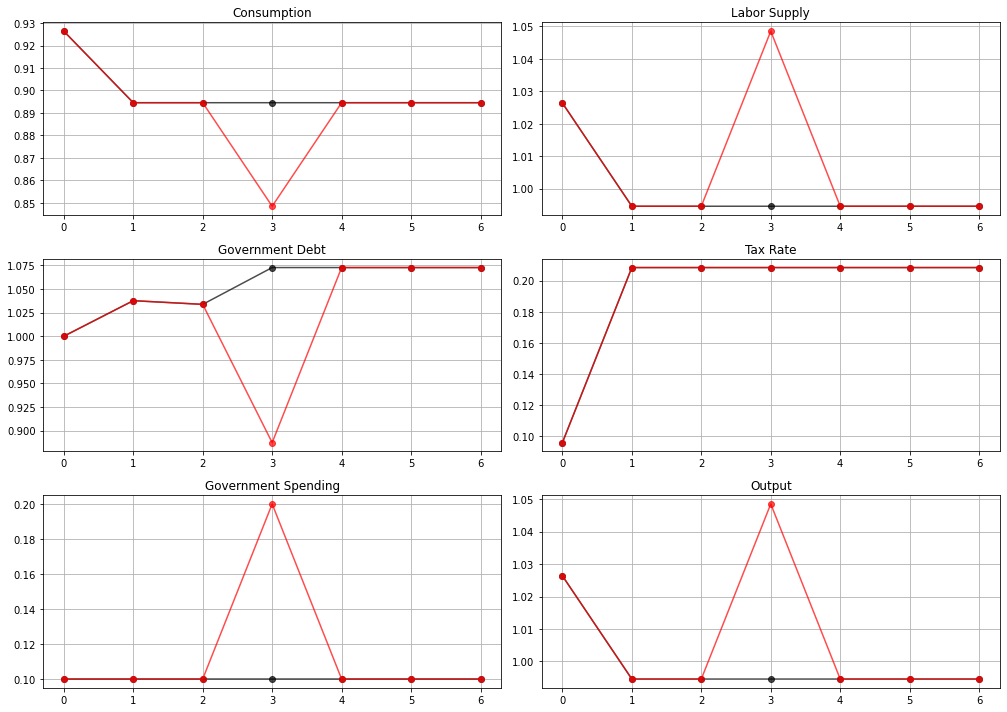

In [6]:
π = np.array([[0, 1, 0,   0,   0,  0],
              [0, 0, 1,   0,   0,  0],
              [0, 0, 0, 0.5, 0.5,  0],
              [0, 0, 0,   0,   0,  1],
              [0, 0, 0,   0,   0,  1],
              [0, 0, 0,   0,   0,  1]])

g = np.array([0.1, 0.1, 0.1, 0.2, 0.1, 0.1])
crra_pref = CRRAutility()

# Solve sequential problem
seq = SequentialLS(crra_pref, π=π, g=g)
sHist_h = np.array([0, 1, 2, 3, 5, 5, 5])
sHist_l = np.array([0, 1, 2, 4, 5, 5, 5])
sim_seq_h = seq.simulate(1, 0, 7, sHist_h)
sim_seq_l = seq.simulate(1, 0, 7, sHist_l)

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
titles = ['Consumption', 'Labor Supply', 'Government Debt',
          'Tax Rate', 'Government Spending', 'Output']

for ax, title, sim_l, sim_h in zip(axes.flatten(),
                                   titles,
                                   sim_seq_l[:6],
                                   sim_seq_h[:6]):
    ax.set(title=title)
    ax.plot(sim_l, '-ok', sim_h, '-or', alpha=0.7)
    ax.grid()

plt.tight_layout()
plt.show()

**Tax smoothing**

* the tax rate is constant for all  $t\geq 1$
    * For $t \geq 1, t \neq 3$, this is a consequence of $g_t$
      being the same at all those dates.
    * For $t = 3$, it is a consequence of the special one-period utility
      function that we have assumed.
    * Under  other one-period utility functions, the time $t=3$ tax rate
      could be either higher or lower than for dates $t \geq 1, t \neq 3$.
* the tax rate is the same at $t=3$ for both the high $g_t$ outcome and the low $g_t$ outcome

We have assumed that at $t=0$, the government owes positive debt $b_0$.

It sets the time $t=0$ tax rate partly with an eye to reducing the value $u_{c,0} b_0$ of $b_0$.

It does this by increasing consumption at time $t=0$ relative to
consumption in later periods.

This has the consequence of *lowering* the time $t=0$ value of the  gross
interest  rate for risk-free loans between periods $t$ and $t+1$, which  equals

$$
R_t = \frac{u_{c,t}}{\beta\mathbb E_{t}[u_{c,t+1}]}
$$

A tax policy that makes  time $t=0$ consumption be  higher than time $t=1$ consumption evidently decreases the
risk-free rate one-period interest rate, $R_t$, at $t=0$.

Lowering the time $t=0$ risk-free interest rate makes time $t=0$
consumption goods cheaper relative to consumption goods at later dates, thereby
lowering the value $u_{c,0} b_0$ of initial government debt $b_0$.

We see this in a figure below that plots the time path for the risk-free interest
rate under both realizations of the time $t=3$ government expenditure shock.

The following plot illustrates how the government lowers the interest rate at
time 0 by raising consumption

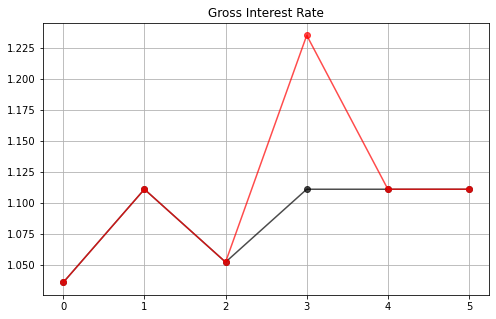

In [7]:
fix, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Gross Interest Rate')
ax.plot(sim_seq_l[-1], '-ok', sim_seq_h[-1], '-or', alpha=0.7)
ax.grid()
plt.show()

### Government Saving

At time  $t=0$ the government evidently *dissaves* since $b_1> b_0$.

* This is a consequence of it setting a *lower* tax rate at $t=0$,
  implying more consumption at $t=0$.

At time $t=1$, the government evidently *saves* since it has set the tax
rate sufficiently high to allow it to set $b_2 < b_1$.

* Its motive for doing this is that it anticipates a likely war at $t=3$.

At time $t=2$ the government trades state-contingent Arrow securities
to hedge against  war at $t=3$.

* It purchases a security that pays off when $g_3 = g_h$.
* It sells a security that  pays off when $g_3 = g_l$.
* These purchases are designed in such a way that regardless of whether or
  not there is a war at $t=3$, the government will begin  period
  $t=4$ with the *same* government debt.
* The time $t=4$ debt level can be serviced with revenues from the
  constant tax rate set at times $t\geq 1$.

At times $t \geq 4$ the government rolls over its debt, knowing that the
tax rate is set at a level that raises enough revenue to pay for government purchases and interest payments
on its debt.

### Time 0 Manipulation of Interest Rate

We have seen that when $b_0>0$, the Ramsey plan sets the time $t=0$
tax rate partly with an eye toward lowering a risk-free interest
rate for one-period loans between times $t=0$ and $t=1$.

By lowering this interest rate, the plan makes time $t=0$ goods cheap
relative to consumption goods at later times.

By doing this, it lowers the value of time $t=0$ debt that it has inherited
and must finance.

### Time 0 and Time-Inconsistency

In the  preceding  example,  the Ramsey tax rate at time 0 differs from its value  at time 1.

To explore what is going on here, let's simplify things by removing  the possibility of war at time $t=3$.

The Ramsey problem then includes no randomness because  $g_t = g_l$ for all $t$.

The figure below plots the Ramsey tax rates and gross interest rates at time
$t=0$ and time $t\geq1$ as functions of the initial government debt
(using the sequential allocation solution and a CRRA utility function defined
above)

/tmp/ipykernel_15274/2711255625.py:130: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  cn0_arr[:] = c0, n0


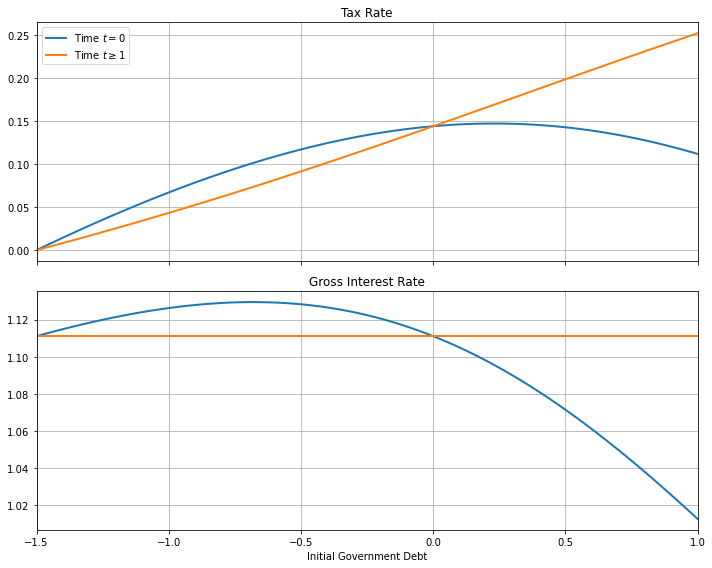

In [8]:
tax_seq = SequentialLS(CRRAutility(), g=np.array([0.15]), π=np.ones((1, 1)))

n = 100
tax_policy = np.empty((n, 2))
interest_rate = np.empty((n, 2))
gov_debt = np.linspace(-1.5, 1, n)

for i in range(n):
    tax_policy[i] = tax_seq.simulate(gov_debt[i], 0, 2)[3]
    interest_rate[i] = tax_seq.simulate(gov_debt[i], 0, 3)[-1]

fig, axes = plt.subplots(2, 1, figsize=(10,8), sharex=True)
titles = ['Tax Rate', 'Gross Interest Rate']

for ax, title, plot in zip(axes, titles, [tax_policy, interest_rate]):
    ax.plot(gov_debt, plot[:, 0], gov_debt, plot[:, 1], lw=2)
    ax.set(title=title, xlim=(min(gov_debt), max(gov_debt)))
    ax.grid()

axes[0].legend(('Time $t=0$', 'Time $t \geq 1$'))
axes[1].set_xlabel('Initial Government Debt')

fig.tight_layout()
plt.show()

The figure indicates  that if the government enters with  positive debt, it sets
a tax rate at $t=0$ that is less than all later tax rates.

By setting  a lower tax rate at $t = 0$, the government raises consumption,
which reduces the *value* $u_{c,0} b_0$ of its  initial debt.

It does this by increasing $c_0$ and thereby lowering $u_{c,0}$.

Conversely, if  $b_{0} < 0$, the Ramsey planner sets the tax rate at $t=0$
higher than in  subsequent periods.

A side effect of lowering time $t=0$ consumption  is that it lowers  the
one-period  interest rate at time $t=0$ below  that of subsequent periods.

There are only two values of initial government debt at which  the tax rate is
constant for all $t \geq 0$.

The first is $b_{0} = 0$

* Here the government can't use the $t=0$ tax rate  to alter  the
  value of the initial debt.

The second occurs when the government enters with sufficiently large  assets
that the Ramsey planner can achieve first best and sets $\tau_t = 0$
for all $t$.

It is only for these two values of initial government debt that the Ramsey
plan is time-consistent.

Another way of saying this is that, except for these two values of initial
government debt, a continuation of a Ramsey plan is not a Ramsey plan.

To illustrate this, consider a Ramsey planner who starts with an initial
government debt  $b_1$ associated with one of the Ramsey plans computed above.

Call $\tau_1^R$ the time $t=0$ tax rate chosen by the Ramsey planner
confronting this value for initial government debt government.

The figure below shows both  the tax rate  at time 1 chosen by our original
Ramsey planner and what a new Ramsey planner would choose for its
time $t=0$ tax rate

/tmp/ipykernel_15274/2711255625.py:130: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  cn0_arr[:] = c0, n0


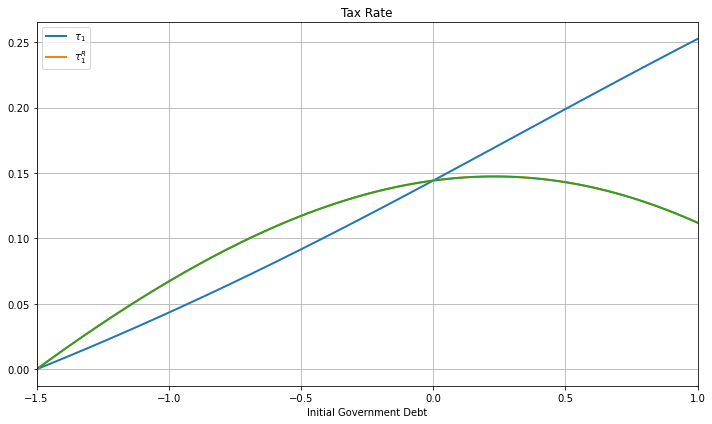

In [9]:
tax_seq = SequentialLS(CRRAutility(), g=np.array([0.15]), π=np.ones((1, 1)))

n = 100
tax_policy = np.empty((n, 2))
τ_reset = np.empty((n, 2))
gov_debt = np.linspace(-1.5, 1, n)

for i in range(n):
    tax_policy[i] = tax_seq.simulate(gov_debt[i], 0, 2)[3]
    τ_reset[i] = tax_seq.simulate(gov_debt[i], 0, 1)[3]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(gov_debt, tax_policy[:, 1], gov_debt, τ_reset, lw=2)
ax.set(xlabel='Initial Government Debt', title='Tax Rate',
       xlim=(min(gov_debt), max(gov_debt)))
ax.legend((r'$\tau_1$', r'$\tau_1^R$'))
ax.grid()

fig.tight_layout()
plt.show()

The tax rates in the figure are equal  for only two values of initial government debt.

### Tax Smoothing and non-CRRA Preferences

The complete tax smoothing for $t \geq 1$ in the preceding example is a
consequence of our having assumed CRRA preferences.

To see what is driving this outcome, we begin by noting that the Ramsey tax rate for $t\geq 1$ is
a time-invariant function $\tau(\Phi,g)$ of the Lagrange multiplier on
the implementability constraint and government expenditures.

For CRRA preferences, we can exploit the relations $U_{cc}c = -\sigma U_c$
and $U_{nn} n = \gamma U_n$ to derive

$$
\frac{(1+(1-\sigma)\Phi)U_c}{(1+(1-\gamma)\Phi)U_n} = 1
$$

from the first-order conditions.

This equation immediately implies that the tax rate is constant.

For other  preferences, the tax rate may not be constant.

For example, let the period utility function be

$$
u(c,n) = \log(c) + 0.69 \log(1-n)
$$

We will create a new class LogUtility to represent this utility function

In [10]:
log_util_data = [
    ('β', float64),
    ('ψ', float64)
]

@jitclass(log_util_data)
class LogUtility:

    def __init__(self,
                 β=0.9,
                 ψ=0.69):

        self.β, self.ψ = β, ψ

    # Utility function
    def U(self, c, l):
        return np.log(c) + self.ψ * np.log(l)

    # Derivatives of utility function
    def Uc(self, c, l):
        return 1 / c

    def Ucc(self, c, l):
        return -c**(-2)

    def Ul(self, c, l):
        return self.ψ / l

    def Ull(self, c, l):
        return -self.ψ / l**2

    def Ucl(self, c, l):
        return 0

    def Ulc(self, c, l):
        return 0


Also, suppose that $g_t$ follows a two-state IID process with equal
probabilities attached to $g_l$ and $g_h$.

To compute the tax rate, we will use both the sequential and recursive approaches described above.

The figure below plots a sample path of the Ramsey tax rate

/tmp/ipykernel_15274/2711255625.py:130: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  cn0_arr[:] = c0, n0


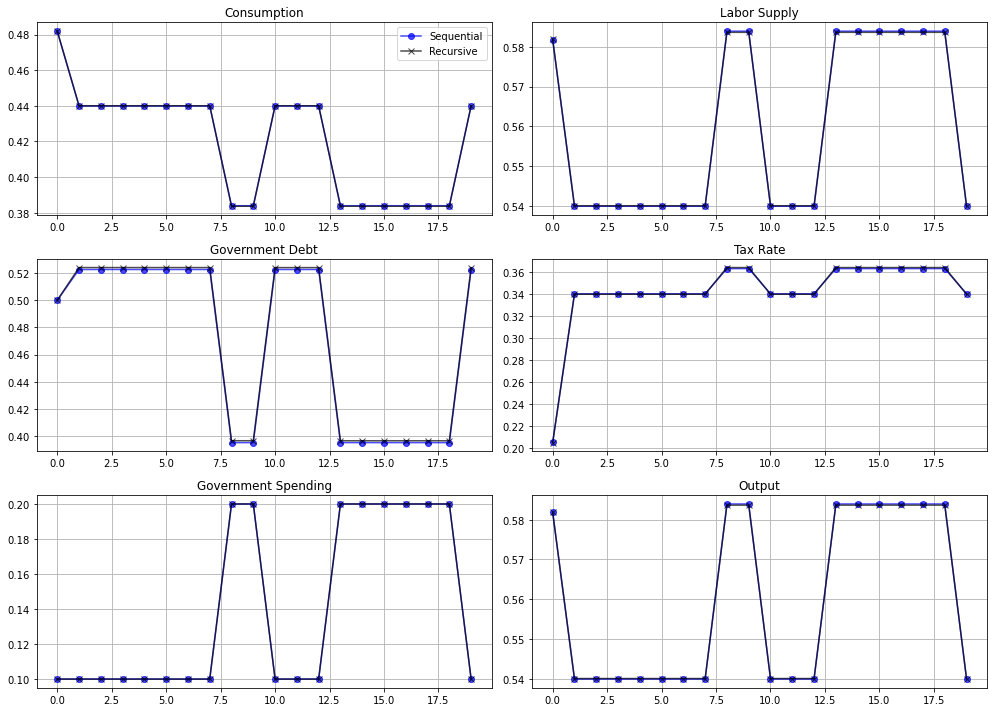

In [11]:
log_example = LogUtility()
# Solve sequential problem
seq_log = SequentialLS(log_example)

# Initialize grid for value function iteration and solve
x_grid = np.linspace(-3., 3., 200)

# Solve recursive problem
rec_log = RecursiveLS(log_example, x_grid)

T_length = 20
sHist = np.array([0, 0, 0, 0, 0,
                  0, 0, 0, 1, 1,
                  0, 0, 0, 1, 1,
                  1, 1, 1, 1, 0])

# Simulate
sim_seq = seq_log.simulate(0.5, 0, T_length, sHist)
sim_rec = rec_log.simulate(0.5, 0, T_length, sHist)

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
titles = ['Consumption', 'Labor Supply', 'Government Debt',
          'Tax Rate', 'Government Spending', 'Output']

for ax, title, sim_s, sim_b in zip(axes.flatten(), titles, sim_seq[:6], sim_rec[:6]):
                                   ax.plot(sim_s, '-ob', sim_b, '-xk', alpha=0.7)
                                   ax.set(title=title)
                                   ax.grid()

axes.flatten()[0].legend(('Sequential', 'Recursive'))
fig.tight_layout()
plt.show()

As should be expected, the recursive and sequential solutions produce almost
identical allocations.

Unlike outcomes with CRRA preferences, the tax rate is not perfectly smoothed.

Instead, the government raises the tax rate when $g_t$ is high.

### Further Comments

A {doc}`related lecture <amss>` describes an extension of the Lucas-Stokey model
by  Aiyagari, Marcet, Sargent, and Seppälä (2002) {cite}`aiyagari2002optimal`.

In the AMSS economy, only a risk-free bond is traded.

That lecture compares the recursive representation of the Lucas-Stokey model
presented in this lecture with  one for an AMSS economy.

By comparing these recursive formulations, we shall glean a sense in which the
dimension of the state is lower in the Lucas Stokey model.

Accompanying that difference in dimension will be  different dynamics of government debt.